imports

In [4]:
import pandas as pd
import shutil
import os
import librosa
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import keras

EXTRAIRE UN DATAFRAME AVEC LES VOCAUX OU L AGE EST PRESENT

In [5]:

# Charger le fichier TSV dans un DataFrame en spécifiant index_col=False
file_path = r'C:\Users\axlco\Downloads\fr\cv-corpus-5.1-2020-06-22\fr\validated.tsv'
df = pd.read_csv(file_path, delimiter='\t', header=None, index_col=False)

# Ajuster les noms des colonnes
df.columns = df.iloc[0]

# Supprimer la première ligne car elle contient les noms de colonnes inutiles maintenant
df = df[1:]

# Filtrer les lignes avec des valeurs non nulles dans la colonne 'age'
df_filtered = df[df['age'].notnull()]

# Afficher le DataFrame résultant
print(df_filtered[['path', 'age']])


C:\Users\axlco\AppData\Local\Temp\ipykernel_22592\1124429334.py:3: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='\t', header=None, index_col=False)


0                               path       age
4       common_voice_fr_20656130.mp3  thirties
12      common_voice_fr_17960551.mp3  twenties
14      common_voice_fr_20344723.mp3  thirties
15      common_voice_fr_17623671.mp3     teens
16      common_voice_fr_18648580.mp3   fifties
...                              ...       ...
413085  common_voice_fr_22393640.mp3   fifties
413086  common_voice_fr_22393638.mp3   fifties
413087  common_voice_fr_22393637.mp3   fifties
413088  common_voice_fr_22393639.mp3   fifties
413089  common_voice_fr_22393641.mp3   fifties

[298284 rows x 2 columns]


REPARTITION DES AGES POUR CHOIX DE LA TAILLE DU DATASET D ENTRAINEMENT

In [6]:
# Calculer la répartition des âges en nombre d'occurrences
age_distribution = df_filtered['age'].value_counts()

# Afficher la répartition des âges
print(age_distribution)


age
twenties     84109
thirties     81491
fourties     51617
fifties      47472
sixties      17740
teens        13502
seventies     2329
eighties        24
Name: count, dtype: int64


In [7]:
# on peut voir qu il y a enormements d echantillon dans chaque classe a part eighties. On va d abord esssayer d entrainer le modele sur une base de donees bien plus courte mais plus fournie que la premiere (3500 dont la moitie etait de la classe thirties). comme la distribution est bien plus homogene on va prendre une petite bdd la plus petite possible

creation echantillon entrainement

In [8]:

# Sélectionner les chemins des fichiers pour les catégories eighties et seventies
selected_paths = df_filtered[df_filtered['age'].isin(['eighties', 'seventies'])]['path'].tolist()

# Sélectionner 20000 autres chemins au hasard
other_paths = df_filtered.sample(n=20000)['path'].tolist()

# Concaténer les deux listes de chemins
all_paths = selected_paths + other_paths

# Définir le nouveau répertoire de destination
destination_directory = r'C:\Users\axlco\OneDrive - ESME\ESME Sudria\5 ème année\Projet\dataset_reduit_homogene'


# Copier les fichiers vers le nouveau répertoire
for audio_file in all_paths:
    source_path = os.path.join(r'C:\Users\axlco\Downloads\fr\cv-corpus-5.1-2020-06-22\fr\clips', audio_file)

    # Vérifier si le fichier source existe avant de le copier
    if os.path.exists(source_path):
        destination_path = os.path.join(destination_directory, audio_file)
        shutil.copy(source_path, destination_path)
    # Aucun affichage si le fichier source n'existe pas

print(f"{len(all_paths)} fichiers ont été copiés vers {destination_directory}.")


22353 fichiers ont été copiés vers C:\Users\axlco\OneDrive - ESME\ESME Sudria\5 ème année\Projet\dataset_reduit_homogene.


creation et affichage du nouvel echantillon d entrainement

In [8]:
destination_directory = r'C:\Users\axlco\OneDrive - ESME\ESME Sudria\5 ème année\Projet\dataset_reduit_homogene'

# Charger le fichier TSV dans un DataFrame
df_tsv = pd.read_csv(file_path, delimiter='\t')
# Liste des fichiers dans le répertoire destination_directory
audio_files = os.listdir(destination_directory)

# Filtrer le DataFrame TSV pour inclure uniquement les lignes correspondant aux fichiers dans destination_directory
df_filtered2 = df_tsv[df_tsv['path'].isin(audio_files)][['path', 'age']]

# Afficher le DataFrame résultant
print(df_filtered2)

                                path        age
29      common_voice_fr_17323684.mp3    fifties
53      common_voice_fr_21260894.mp3  seventies
54      common_voice_fr_21332921.mp3   twenties
209     common_voice_fr_19193597.mp3  seventies
233     common_voice_fr_19935440.mp3    sixties
...                              ...        ...
413046  common_voice_fr_22188661.mp3    fifties
413052  common_voice_fr_22188758.mp3    fifties
413057  common_voice_fr_22188796.mp3    fifties
413059  common_voice_fr_22192627.mp3    fifties
413076  common_voice_fr_22393600.mp3    fifties

[22197 rows x 2 columns]


In [9]:
# Calculer la répartition des âges en nombre d'occurrences
age_distribution2 = df_filtered2['age'].value_counts()

# Afficher la répartition des âges
print(age_distribution2)


age
twenties     5711
thirties     5413
fourties     3424
fifties      3160
seventies    2329
sixties      1233
teens         903
eighties       24
Name: count, dtype: int64


avoir la duree des enregistrements

In [10]:

# Fonction pour obtenir la durée d'un fichier audio en secondes
def get_audio_duration(file_path):
    audio, _ = librosa.load(file_path, sr=None)
    duration = len(audio) / _  # Durée en secondes
    return duration

# Ajouter une colonne de durée au DataFrame df_filtered
df_filtered2['duration'] = df_filtered2['path'].apply(lambda x: get_audio_duration(os.path.join(destination_directory, x)))

# Afficher le DataFrame résultant
print(df_filtered2)

                                path        age  duration
29      common_voice_fr_17323684.mp3    fifties     6.600
53      common_voice_fr_21260894.mp3  seventies     5.160
54      common_voice_fr_21332921.mp3   twenties     5.664
209     common_voice_fr_19193597.mp3  seventies     6.048
233     common_voice_fr_19935440.mp3    sixties     9.864
...                              ...        ...       ...
413046  common_voice_fr_22188661.mp3    fifties     4.992
413052  common_voice_fr_22188758.mp3    fifties     4.656
413057  common_voice_fr_22188796.mp3    fifties     5.856
413059  common_voice_fr_22192627.mp3    fifties     6.504
413076  common_voice_fr_22393600.mp3    fifties     5.112

[22197 rows x 3 columns]


In [11]:
# Obtenez des statistiques sur la colonne 'duration'
duration_stats = df_filtered2['duration'].describe()

# Affichez les statistiques
print(duration_stats)

count    22197.000000
mean         4.793791
std          1.647934
min          0.744000
25%          3.576000
50%          4.704000
75%          5.880000
max         12.504000
Name: duration, dtype: float64


In [12]:
#on peut voir que 75% des audios ont une duree de plus de 3.57 secondes

In [13]:
# Fonction pour charger le fichier audio et obtenir le signal sous forme de vecteur 1D
def load_audio(file_path):
    # Chargement du fichier audio
    y, sr = librosa.load(file_path, sr=None)  # Ajout de sr=None pour obtenir le taux d'échantillonnage
    return y, sr

def preprocess_audio(file_path, max_duration=3.5):
    # Charger le fichier audio avec Librosa
    audio, sr = librosa.load(file_path, duration=max_duration)

    # Tronquer ou remplir le signal pour qu'il ait la même longueur que max_duration * sr
    target_length = int(max_duration * sr)
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        audio = audio[:target_length]

    return audio, sr  # Retourner également le taux d'échantillonnage

X = []  # Liste pour stocker les vecteurs 1D des signaux audio

for idx in tqdm(range(len(df_filtered2)), desc='Traitement des signaux audio', colour='white'):
    file_name = df_filtered2.iloc[idx]['path']
    filepath = os.path.join(destination_directory, file_name)

    # Appliquer la fonction de prétraitement sans spécifier la durée maximale
    audio_signal, sr = preprocess_audio(filepath)

    # Ajouter le vecteur 1D à la liste X
    X.append(audio_signal)

# Calculer la durée maximale après avoir rempli la liste X
max_duration = max(len(audio) for audio in X) / sr


Traitement des signaux audio: 100%|██████████| 22197/22197 [03:22<00:00, 109.39it/s]


In [14]:

# Convertir la liste X en un tableau NumPy
X_array = np.array(X)

# Afficher des informations sur le tableau
print("Taille du tableau X:", X_array.shape)
print("Dimension du tableau X:", X_array.ndim)
print("Type de données du tableau X:", X_array.dtype)

Taille du tableau X: (22197, 77175)
Dimension du tableau X: 2
Type de données du tableau X: float32


In [15]:
# Extraire les labels de l'âge de df_with_age_minfour
y = df_filtered2['age'].tolist()


In [16]:
# Créer un mapping personnalisé pour le label encoding
age_label_mapping = {'teens': 1, 'twenties': 2, 'thirties': 3, 'fourties': 4, 'fifties': 5, 'sixties': 6, 'seventies': 7, 'eighties': 8, 'nineties': 9}

# Appliquer le mapping pour créer une nouvelle colonne 'y_age_encoded'
df_filtered2['y_age_encoded'] = df_filtered2['age'].map(age_label_mapping)

# Afficher les valeurs encodées
print(df_filtered2['y_age_encoded'])

# Afficher les classes attribuées après l'encodage des étiquettes d'âge
age_classes = df_filtered2['y_age_encoded'].unique()
print("Classes d'âge après encodage:", age_classes)

# Afficher la correspondance entre les labels originaux et les classes attribuées
label_class_mapping = dict(zip(df_filtered2['age'], df_filtered2['y_age_encoded']))
print("Mapping des labels originaux aux classes attribuées:", label_class_mapping)


29        5
53        7
54        2
209       7
233       6
         ..
413046    5
413052    5
413057    5
413059    5
413076    5
Name: y_age_encoded, Length: 22197, dtype: int64
Classes d'âge après encodage: [5 7 2 6 1 4 3 8]
Mapping des labels originaux aux classes attribuées: {'fifties': 5, 'seventies': 7, 'twenties': 2, 'sixties': 6, 'teens': 1, 'fourties': 4, 'thirties': 3, 'eighties': 8}


In [17]:
y = df_filtered2['y_age_encoded'].tolist()
print(y)

[5, 7, 2, 7, 6, 1, 7, 4, 2, 6, 6, 2, 4, 7, 7, 3, 7, 7, 2, 4, 3, 2, 7, 7, 7, 7, 7, 2, 4, 3, 2, 5, 3, 3, 4, 3, 2, 2, 4, 3, 2, 4, 2, 1, 1, 7, 7, 7, 7, 7, 7, 2, 3, 3, 4, 4, 2, 1, 5, 2, 2, 4, 6, 6, 4, 2, 1, 2, 2, 2, 1, 2, 6, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 7, 7, 7, 7, 4, 2, 2, 2, 6, 4, 2, 2, 3, 7, 7, 7, 7, 2, 4, 7, 7, 7, 7, 1, 5, 2, 4, 5, 2, 7, 7, 7, 7, 2, 6, 6, 6, 6, 3, 2, 7, 7, 7, 7, 6, 3, 7, 7, 7, 7, 5, 3, 3, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 5, 1, 4, 4, 2, 3, 2, 3, 3, 6, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 7, 7, 7, 7, 7, 2, 4, 4, 6, 4, 2, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 1, 1, 6, 5, 5, 2, 2, 5, 6, 6, 6, 6, 4, 5, 2, 3, 3, 2, 2, 2, 2, 3, 2, 7, 7, 7, 7, 7, 5, 5, 4, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 1, 4, 4, 4, 2, 2, 2, 2, 7, 7, 7, 7, 7, 4, 3, 2, 3, 6, 2, 5, 4, 2, 2, 7, 7, 7, 7, 7, 1, 4, 3, 4, 2, 7, 7, 7, 7, 7, 6, 2, 3, 2, 6, 2, 6, 4, 2, 2, 5, 7, 7, 7, 7, 7, 2, 4, 4, 4, 3, 7, 7, 7, 7, 7, 4, 2, 2, 7, 7, 7, 7, 7, 2, 3, 3, 4, 1, 1, 3, 3, 7, 7, 7, 7, 7, 2, 2, 

In [18]:

# Convertir les listes en tableaux NumPy
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.2, random_state=42)

# Ajouter une dimension pour correspondre à la forme attendue par le modèle
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
""""
# Convertir les étiquettes en format catégoriel (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
"""


"""
# Créer le modèle CNN 1D pour la classification d'âge
cnn_model_classification = Sequential()

# Ajouter une couche de convolution avec une fonction d'activation relu
cnn_model_classification.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(77175, 1)))

# Ajouter une couche de pooling
cnn_model_classification.add(MaxPooling1D(pool_size=2))

# Ajouter une autre couche de convolution et de pooling
cnn_model_classification.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
cnn_model_classification.add(MaxPooling1D(pool_size=2))

# Aplatir les données pour les passer à une couche Dense
cnn_model_classification.add(Flatten())

# Ajouter une couche Dense avec une fonction d'activation relu
cnn_model_classification.add(Dense(64, activation='relu'))

# Ajouter la couche de sortie avec une fonction d'activation softmax pour la classification
cnn_model_classification.add(Dense(9, activation='softmax'))

# Compiler le modèle
cnn_model_classification.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher un résumé du modèle
cnn_model_classification.summary()

# Entraîner le modèle
history_classification = cnn_model_classification.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

"""

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


cnn_model_classification = build_model((int(3.5*sr), 1), 9)

cnn_model_classification.summary()

# Compile the model using Adam's default learning rate
"""cnn_model_classification.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)"""

cnn_model_classification.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

history_classification = cnn_model_classification.fit(
    X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

# Afficher les performances
print("Performances sur l'ensemble d'entraînement :")
train_loss, train_accuracy = cnn_model_classification.evaluate(X_train, y_train, verbose=0)
print(f"Loss: {train_loss}, Accuracy: {train_accuracy}")

print("\nPerformances sur l'ensemble de test :")
test_loss, test_accuracy = cnn_model_classification.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {test_loss}, Accuracy: {test_accuracy}")

Shape of X_train: (17757, 77175, 1)
Shape of y_train: (17757,)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 77175, 1)]           0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 77175, 16)            64        ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 77175, 16)            0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 77175, 16)            784       ['activation[0][0]']          
                               

139/139 [==============================] - 233s 2s/step


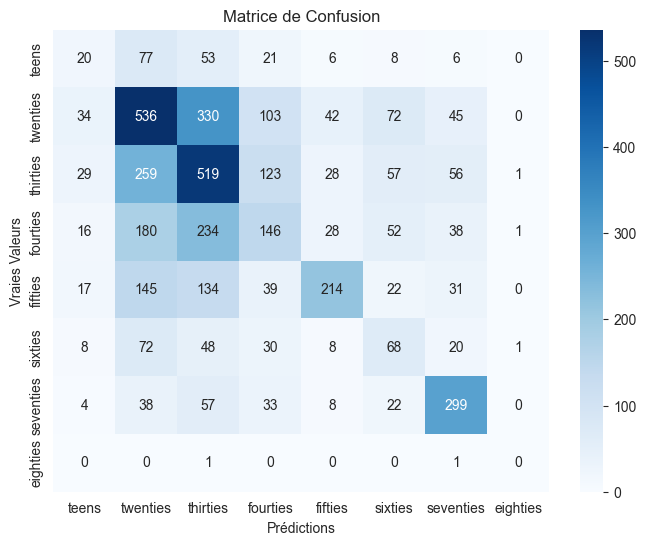

Rapport de classification :
              precision    recall  f1-score   support

       teens       0.16      0.10      0.13       191
    twenties       0.41      0.46      0.43      1162
    thirties       0.38      0.48      0.42      1072
    fourties       0.29      0.21      0.25       695
     fifties       0.64      0.36      0.46       602
     sixties       0.23      0.27      0.24       255
   seventies       0.60      0.65      0.62       461
    eighties       0.00      0.00      0.00         2

    accuracy                           0.41      4440
   macro avg       0.34      0.32      0.32      4440
weighted avg       0.41      0.41      0.40      4440



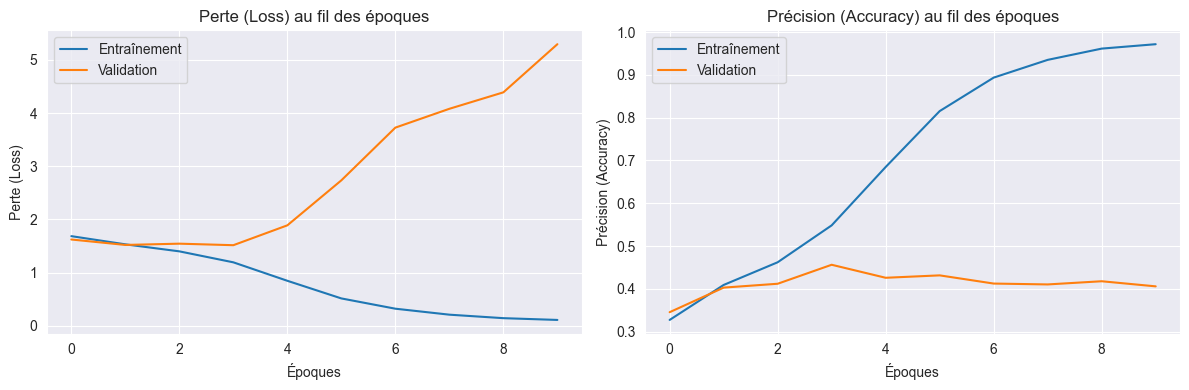

In [22]:


# Évaluation du modèle sur l'ensemble de test
y_pred = cnn_model_classification.predict(X_test)

# Convertir les prédictions en classes
y_pred_classes = np.argmax(y_pred, axis=1)
#y_true = np.argmax(y_test, axis=1)
y_true = y_test


# Labels des classes
class_labels = ["teens", "twenties", "thirties", "fourties", "fifties", "sixties", "seventies", "eighties"]

# Afficher la matrice de confusion avec seaborn
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.show()

# Afficher le rapport de classification
class_report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Rapport de classification :")
print(class_report)

# ... (le reste du code pour les graphiques de perte et de précision)


# Afficher la perte et la précision au fil des époques
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_classification.history['loss'], label='Entraînement')
plt.plot(history_classification.history['val_loss'], label='Validation')
plt.title('Perte (Loss) au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(history_classification.history['accuracy'], label='Entraînement')
plt.plot(history_classification.history['sparse_categorical_accuracy'], label='Entraînement')
#plt.plot(history_classification.history['val_accuracy'], label='Validation')
plt.plot(history_classification.history['val_sparse_categorical_accuracy'], label='Validation')
plt.title('Précision (Accuracy) au fil des époques')
plt.xlabel('Époques')
plt.ylabel('Précision (Accuracy)')
plt.legend()

plt.tight_layout()
plt.show()
